Importing libraries

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Data

In [7]:
data = pd.read_csv('/content/drive/MyDrive/Project.csv')

Reading Data

In [8]:
data.shape

(620, 12)

In [9]:
data.head()

N   P    K   ph    EC     S     Cu      Fe     Mn     Zn      B  \
0  143  69  217  5.9  0.58  0.23  10.20  116.35  59.96  54.85  21.29   
1  170  36  216  5.9  0.15  0.28  15.69  114.20  56.87  31.28  28.62   
2  158  66  219  6.8  0.34  0.20  15.29   65.87  51.81  57.12  27.59   
3  133  45  207  6.4  0.94  0.21   8.48  103.10  43.81  68.50  47.29   
4  132  48  218  6.7  0.54  0.19   5.59   63.40  56.40  46.71  31.04   

         label  
0  pomegranate  
1  pomegranate  
2  pomegranate  
3  pomegranate  
4  pomegranate

In [10]:
data['label'].unique()


array(['pomegranate', 'mango', 'grapes', 'mulberry', 'ragi', 'potato'],
      dtype=object)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       620 non-null    int64  
 1   P       620 non-null    int64  
 2   K       620 non-null    int64  
 3   ph      620 non-null    float64
 4   EC      620 non-null    float64
 5   S       620 non-null    float64
 6   Cu      620 non-null    float64
 7   Fe      620 non-null    float64
 8   Mn      620 non-null    float64
 9   Zn      620 non-null    float64
 10  B       620 non-null    float64
 11  label   620 non-null    object 
dtypes: float64(8), int64(3), object(1)
memory usage: 58.2+ KB


In [12]:
data.columns

Index(['N', 'P', 'K', 'ph', 'EC', 'S', 'Cu', 'Fe', 'Mn', 'Zn', 'B', 'label'], dtype='object')

In [13]:
data.rename(columns = {'ph':'pH'}, inplace = True)
data.columns

Index(['N', 'P', 'K', 'pH', 'EC', 'S', 'Cu', 'Fe', 'Mn', 'Zn', 'B', 'label'], dtype='object')

In [14]:
data.describe()

N           P           K          pH          EC           S  \
count  620.000000  620.000000  620.000000  620.000000  620.000000  620.000000   
mean   135.701613   52.508065  161.401613    6.106290    0.885468    0.484085   
std     31.808083   24.673538   81.285780    0.693782    0.637214    5.775388   
min     30.000000   10.000000   51.000000    4.500000    0.010000    0.011100   
25%    116.000000   30.000000   89.000000    5.700000    0.297500    0.086000   
50%    138.000000   54.000000  157.500000    6.100000    0.780000    0.168000   
75%    160.000000   75.000000  206.000000    6.500000    1.390000    0.240000   
max    198.000000  100.000000  369.000000    8.000000    2.480000  113.200000   

               Cu          Fe           Mn          Zn           B  
count  620.000000  620.000000   620.000000  620.000000  620.000000  
mean    17.315452  117.212500   219.905887   34.340839   28.750710  
std      6.441150   62.775199   341.998793   11.543871   19.636447  
min      0.180000    3.810000    20.580000   17.990000    1.020000  
25%     12.592500   68.312500    58.785000   24.727500   13.442500  
50%     16.910000  108.245000    73.580000   31.425000   23.225000  
75%     21.102500  155.620000   163.665000   43.542500   42.767500  
max     35.000000  276.720000  1572.540000   70.000000   74.560000

# Data Preprocessing

Checking for missing Data

In [15]:
data.isnull().sum()

N        0
P        0
K        0
pH       0
EC       0
S        0
Cu       0
Fe       0
Mn       0
Zn       0
B        0
label    0
dtype: int64

Check for imbalanced data

In [16]:
data['label'].value_counts()

pomegranate    104
mango          104
grapes         104
mulberry       104
ragi           104
potato         100
Name: label, dtype: int64

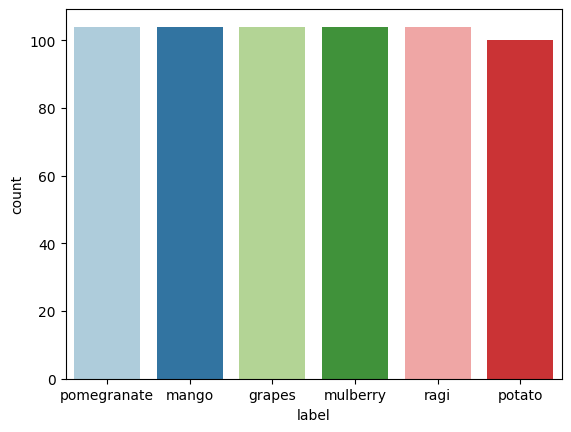

In [17]:
g = sns.countplot(x=data['label'], palette='Paired')
g = g.set_xticklabels(['pomegranate', 'mango', 'grapes', 'mulberry', 'ragi', 'potato'])

Splitting to train and test sets

In [18]:
X = data.iloc[:,:11]
label = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, label, train_size=0.8, random_state=42, stratify=label)

In [19]:
y_train.value_counts()

mango          84
pomegranate    83
mulberry       83
ragi           83
grapes         83
potato         80
Name: label, dtype: int64

In [20]:
#Defining variables
features = X_train.columns
train = pd.concat([X_train, y_train], axis=1)

Outlier detection

In [21]:
from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        outlier_indices.extend(outlier_list_col)

    outlier_indices_counter = Counter(outlier_indices)
    multiple_outliers = [ k for k, v in outlier_indices_counter.items() if v > n]

    return multiple_outliers, outlier_indices

In [22]:
outliers_to_drop, outliers = detect_outliers(X_train, 2, features)
print(f"{len(outliers)} samples contain outliers, {len(outliers_to_drop)} of them are outliers in more then two features.")

94 samples contain outliers, 0 of them are outliers in more then two features.


"Detect outliers" function indicates thet we don't have any outliers to drop.

In order to confirm it, we will display a box plot for each feature:

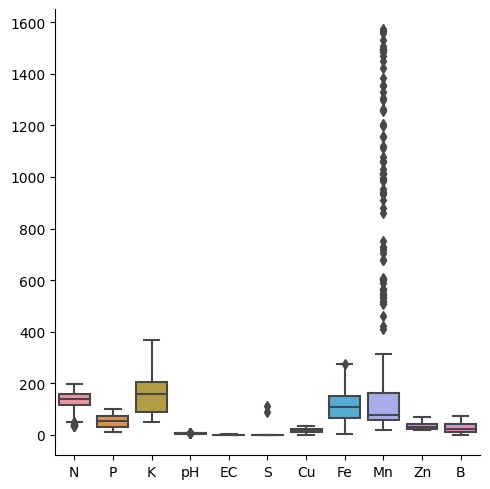

In [23]:
sns.catplot(data=X_train ,kind="box")

Focusing on Mn and S, which have the most significant outliers samples.

Checking Manganese Outliers

<Axes: ylabel='Mn'>

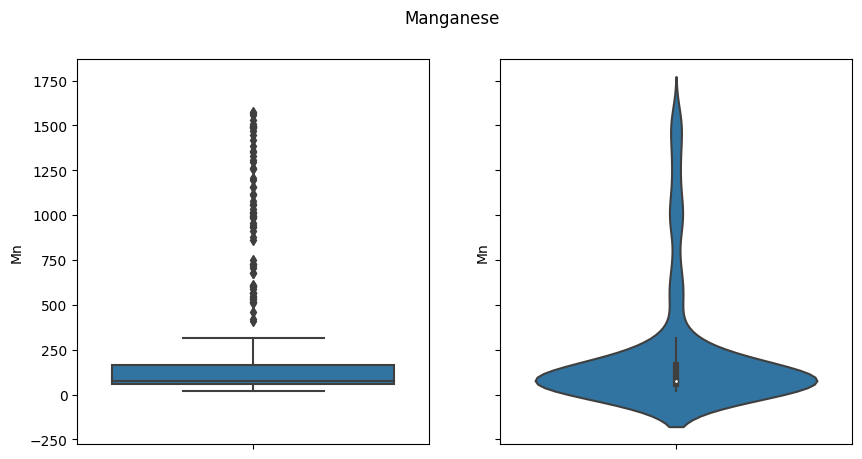

In [24]:
fig, axs = plt.subplots(1,2, figsize=(10, 5), sharey=True)
fig.suptitle('Manganese')
sns.boxplot(ax=axs[0], y='Mn',  data=X_train)
sns.violinplot(ax=axs[1], y='Mn',  data=X_train)

Unnegligible number of outliers are obtain in box plot for Manganese.

The distribution shown in violin plot is normal for most of the data and uniform for outlier samples.

Therefore I decide to keep all samples.

In [25]:
feat_without_Mn = features.drop(['Mn'])

In [26]:
outliers_to_drop, outliers = detect_outliers(X_train, 2, feat_without_Mn)
print(f"{len(outliers)} samples contain outliers, {len(outliers_to_drop)} of them are outliers in more then two features.")

24 samples contain outliers, 0 of them are outliers in more then two features.


Checking Sulfur Outliers
The two outlier samples of Sulfur (S) are extremely far from IQR.

<Axes: ylabel='S'>

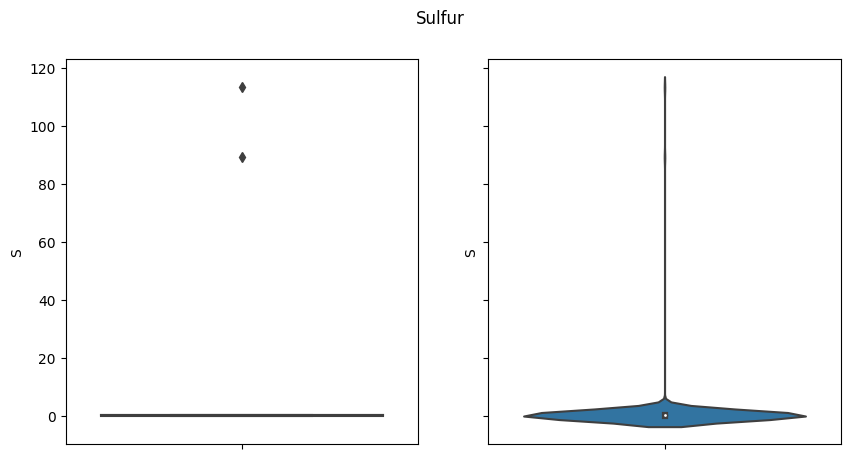

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True)
fig.suptitle('Sulfur')
sns.boxplot(ax=ax[0], y='S',  data=X_train)
sns.violinplot(ax=ax[1], y='S',  data=X_train)

Dropping Outliers

In [28]:
outliers_to_drop, S_outliers_indecies = detect_outliers(X_train, 1, 'S')
S_outliers_indecies

[414, 415]

In [29]:
X_train = X_train.drop(S_outliers_indecies, axis=0).reset_index(drop=True)
y_train = y_train.drop(S_outliers_indecies, axis=0).reset_index(drop=True)
train = train.drop(S_outliers_indecies, axis=0).reset_index(drop=True)

#Normalization of data

Skewness Correction

In [31]:
skewed_feats = X_train.apply(lambda x: x.skew()).sort_values(ascending=False)
print("\nSkew in numerical features (origin X_train): \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
skewness.head(11)


Skew in numerical features (origin X_train): 



Skew
Mn  2.523
Zn  0.733
Fe  0.702
K   0.680
EC  0.670
B   0.645
Cu  0.449
pH -0.011
S  -0.055
P  -0.072
N  -0.690

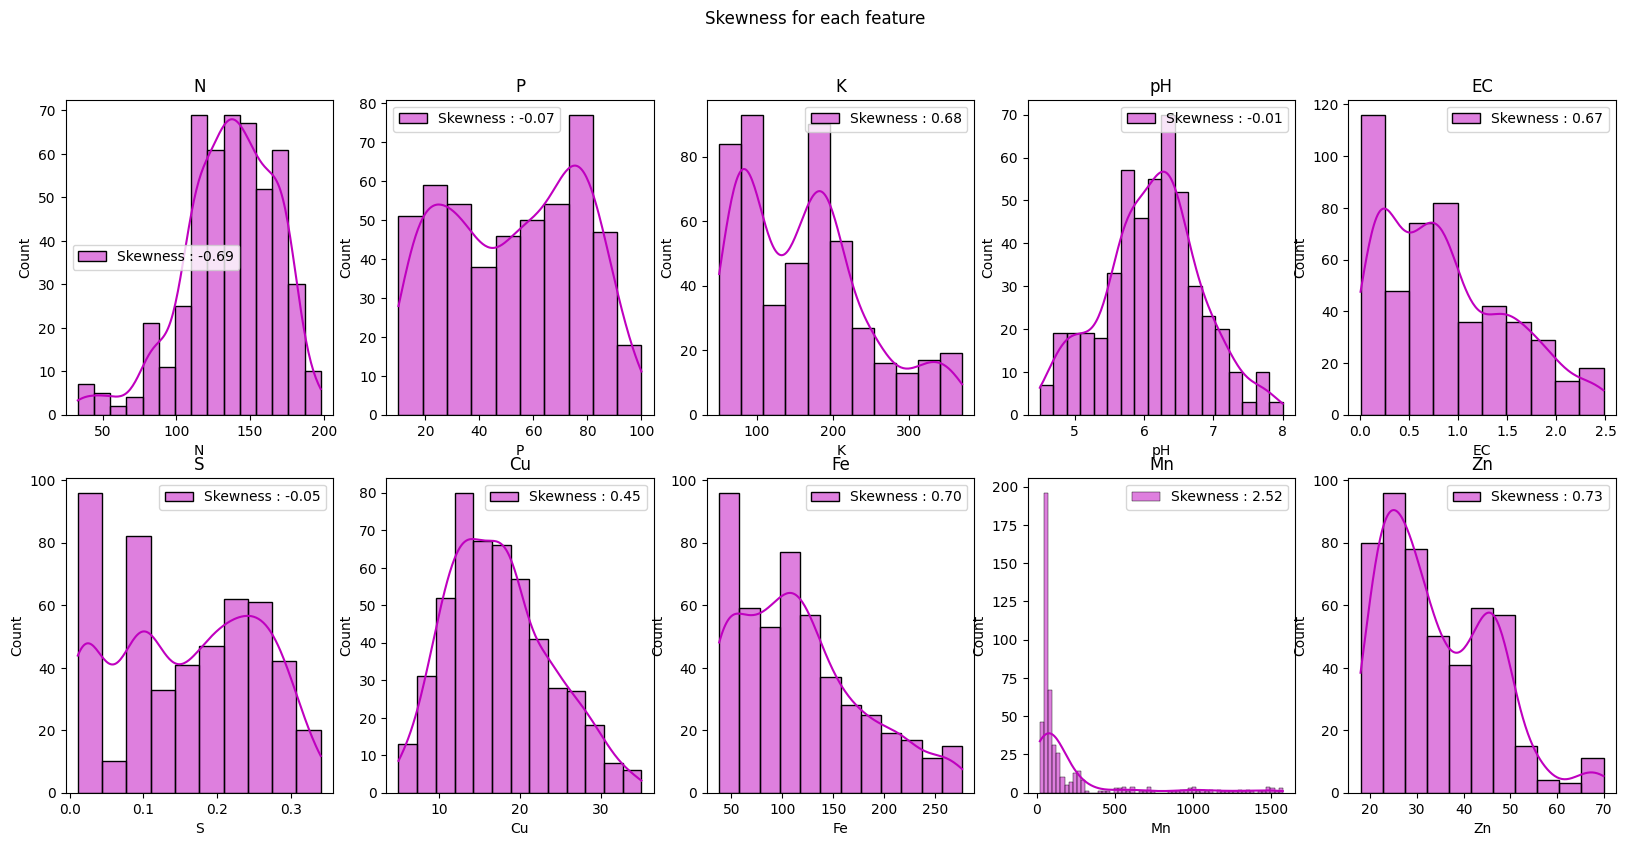

In [32]:
features = X_train.columns


fig, axs = plt.subplots(2, 5, figsize=(20, 9))
fig.suptitle('Skewness for each feature')
for i, ax in enumerate(axs.ravel()):
    g = sns.histplot(X_train.iloc[:,i], color='m', label='Skewness : %.2f'%(X_train.iloc[:,i].skew()), ax=ax, kde=True)
    g = g.legend(loc='best')
    ax.set_title(features[i])

In [33]:
X_train['Mn']= stats.boxcox(X_train['Mn'], lmbda=0.001)
X_train['Zn']= stats.boxcox(X_train['Zn'], lmbda=0.5)
X_train['Fe']= stats.boxcox(X_train['Fe'], lmbda=0.5)
X_train['K']= stats.boxcox(X_train['K'], lmbda=0.5)
X_train['EC']= stats.boxcox(X_train['EC'], lmbda=0.5)

Text(0.5, 1.0, 'Mn skewness after correction:')

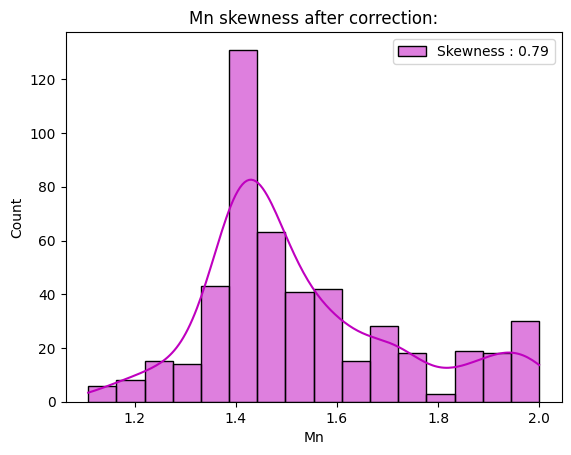

In [34]:
X_train['Mn'] = X_train['Mn'].map(lambda i: np.log(i) if i> 0 else 0)

g = sns.histplot(X_train['Mn'], color='m', label='Skewness : %.2f'%(X_train['Mn'].skew()), kde=True)
g.legend(loc='best')
g.set_title("Mn skewness after correction:")

Scaling

In [35]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

# Exploratory Data Analysis (EDA)

Correlation matrix

<Axes: >

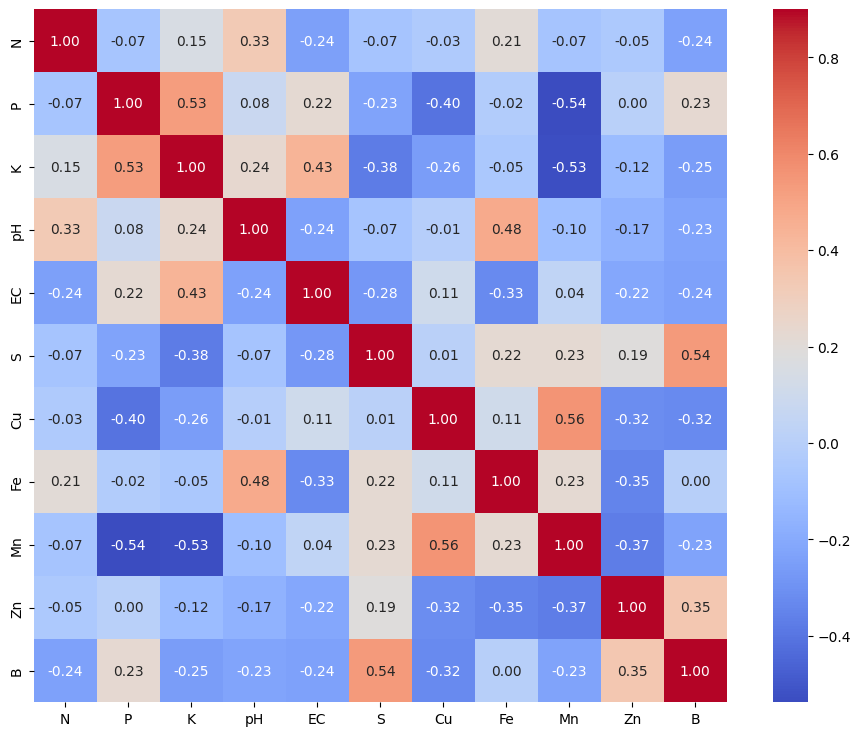

In [36]:
corrmat = X_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, annot=True, fmt=".2f", cmap = "coolwarm")

Correlation map indicates very low correlation between all features, which emphasizes the significance of each individual feature.

It seems to have weak positive correlation between the pairs: Potasium (K) & Phosphorus (P), Sulphur (S) & Boron (B) and Cooper (Cu) & Manganese (Mn).

A weak negative correlation is received between Manganese (Mn) & Phosphorus (P)

Pair plot

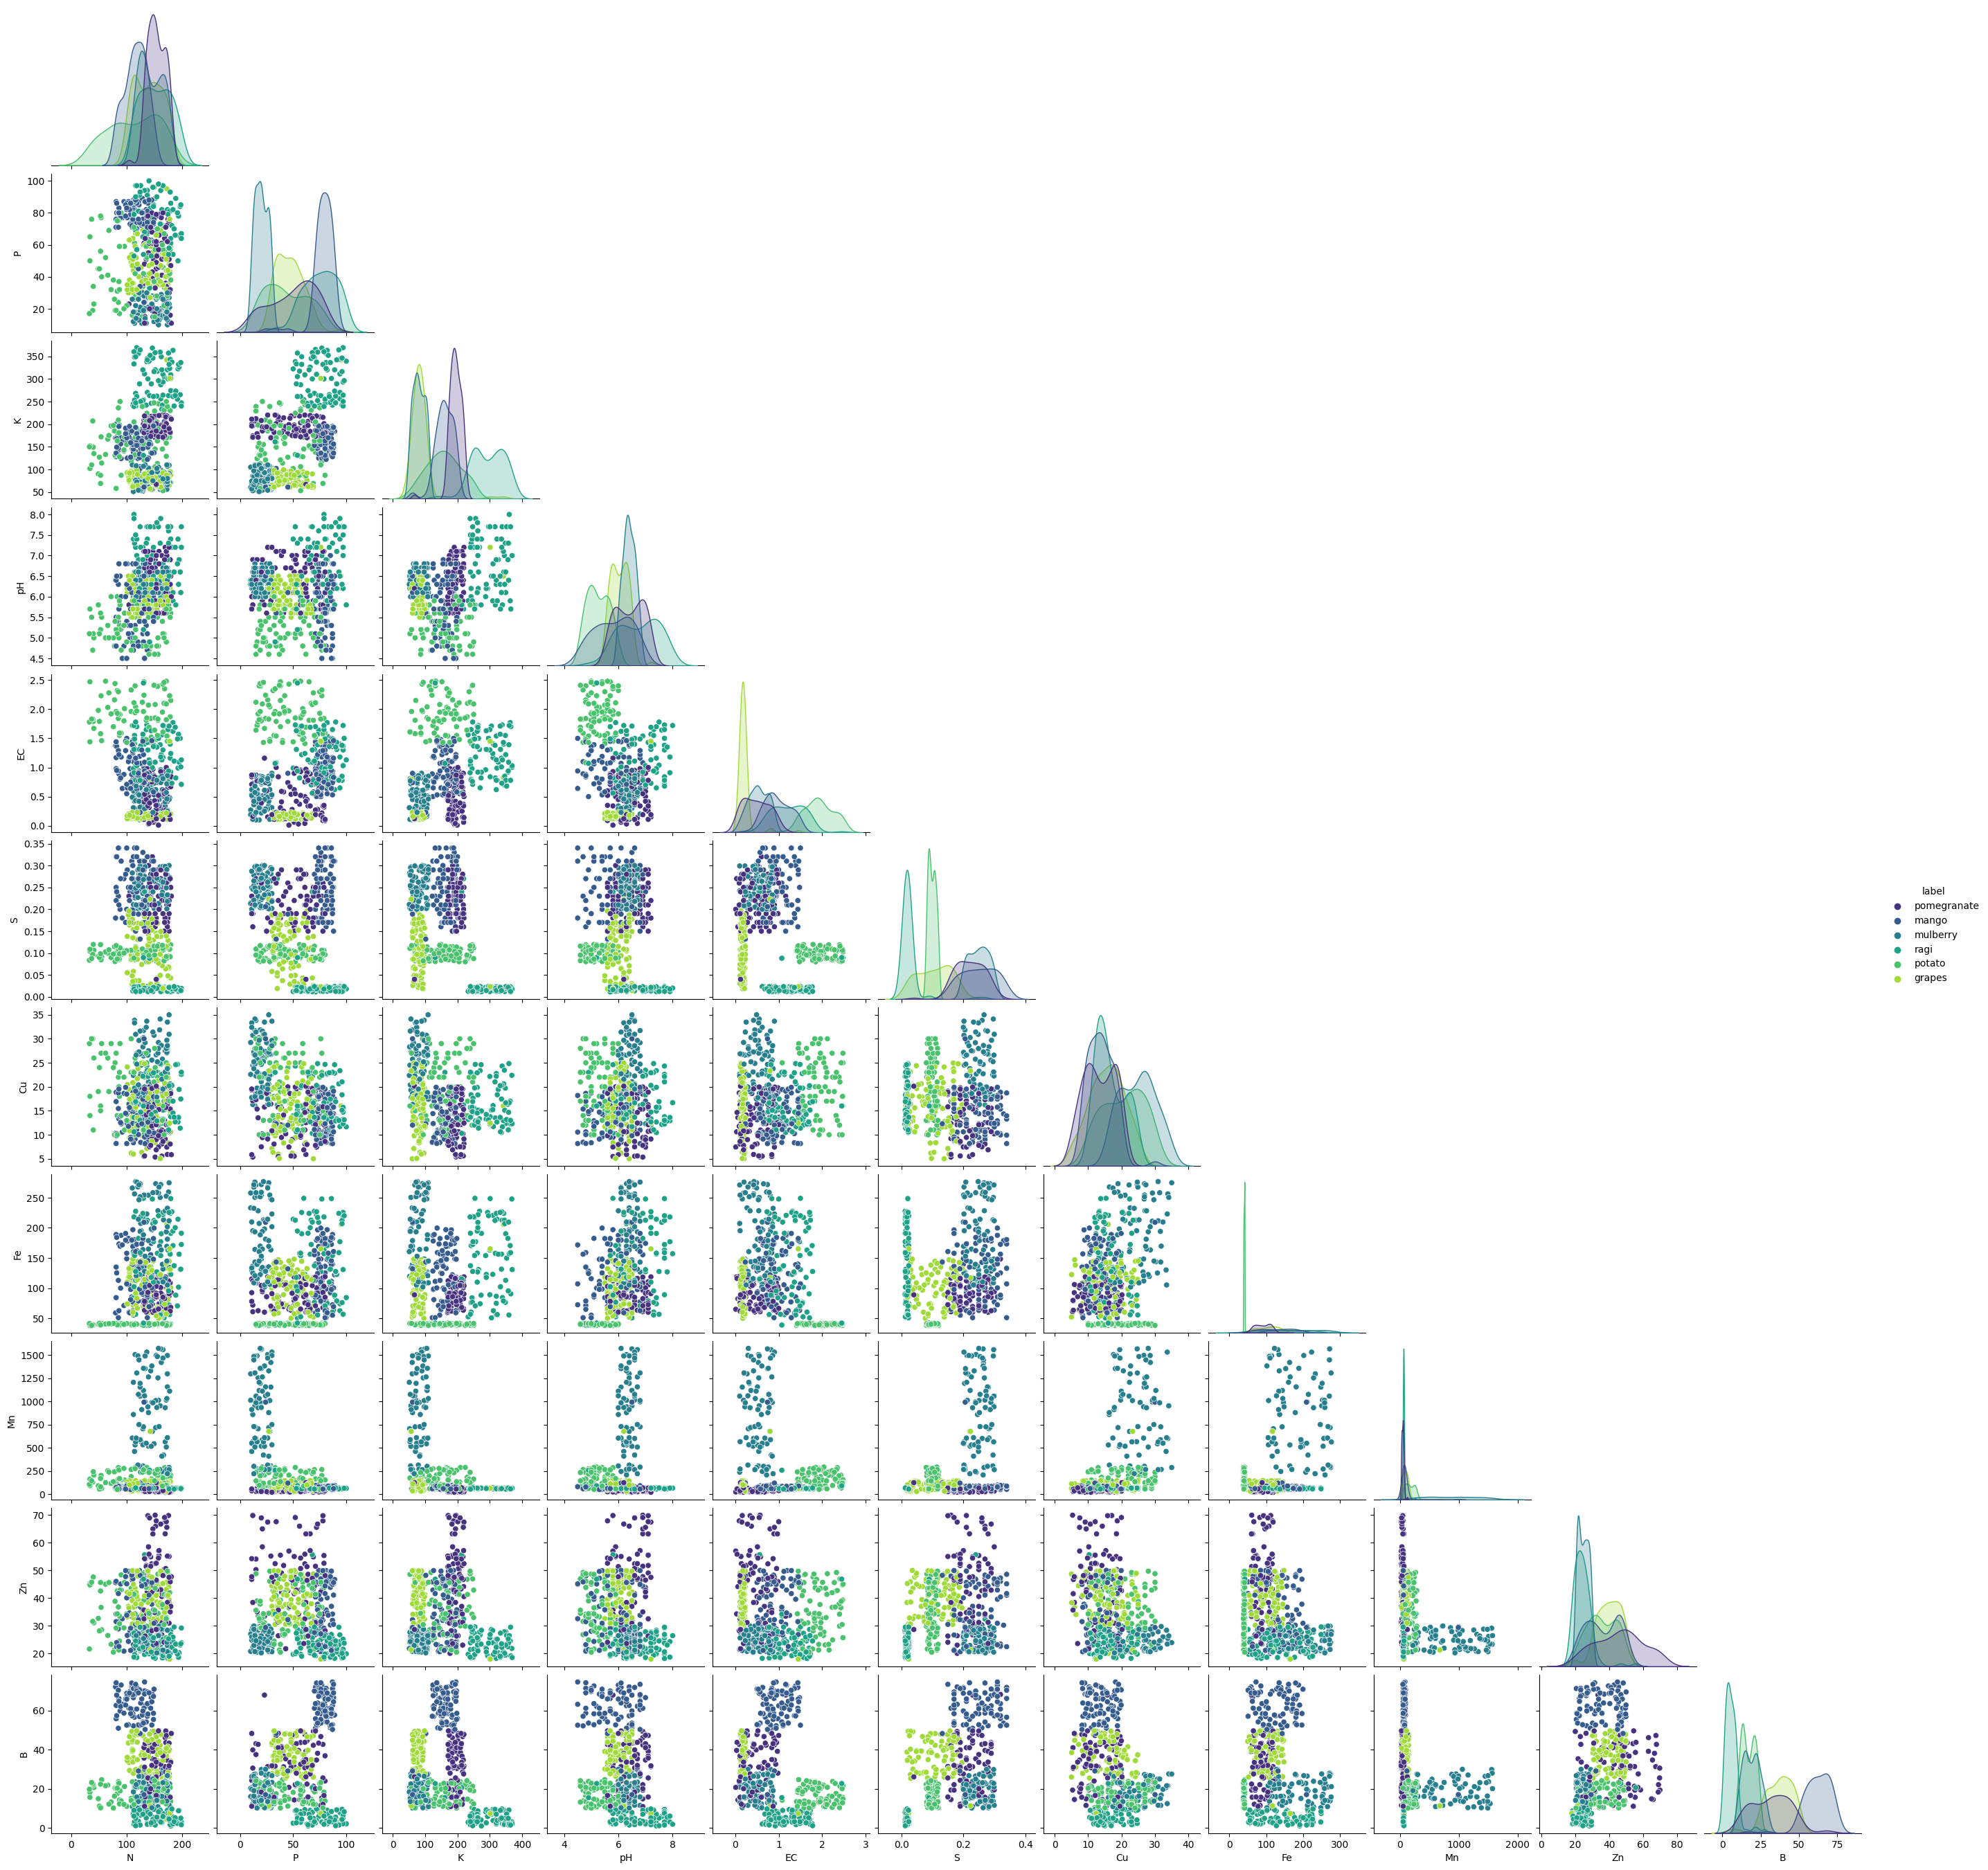

In [37]:
sns.pairplot(train, hue='label', palette='viridis', corner=True)

<Axes: >

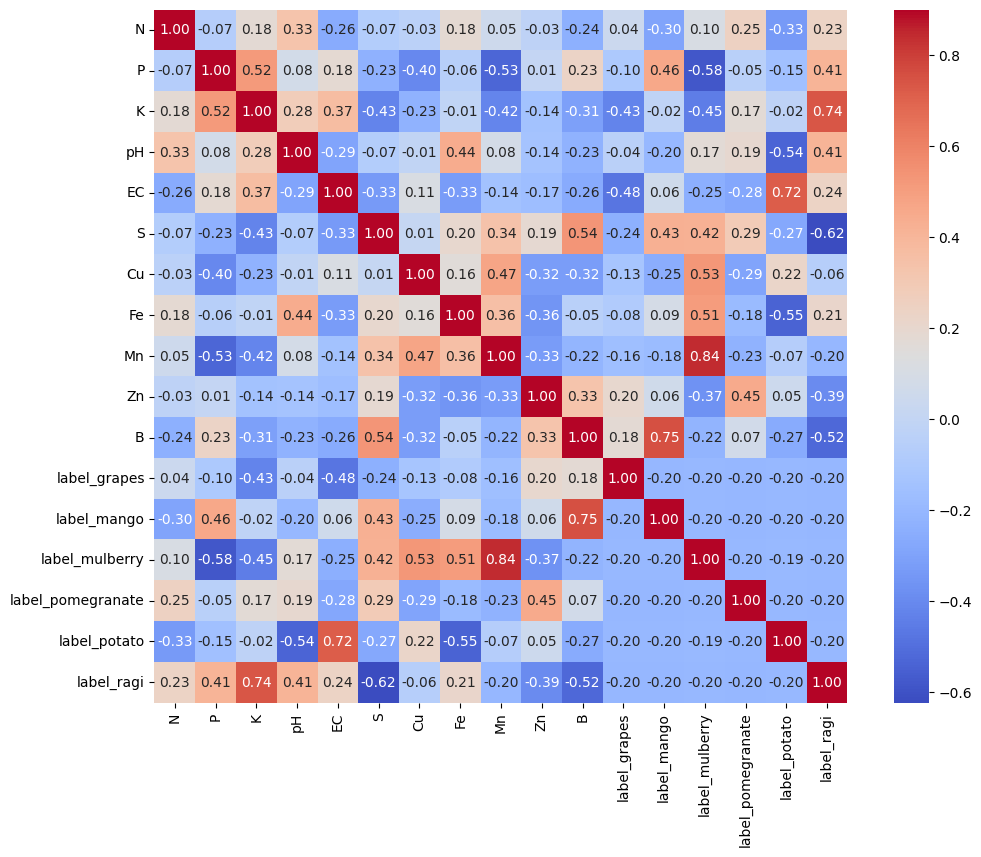

In [38]:
train = pd.get_dummies(train, drop_first=False, columns=['label'])

corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, annot=True, fmt=".2f", cmap = "coolwarm")

Mango is associative with high Boron (B).

Mulberry is associative with high Manganese (Mn).

Ragi is associative with high Potassium (K).

Potato is associative with high electrical conducativity (EC).

Visualizstion of data by label (t-SNE)

In [39]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_train_scaled)
tsne.shape

(494, 2)

In [40]:
X_train.shape

(494, 11)

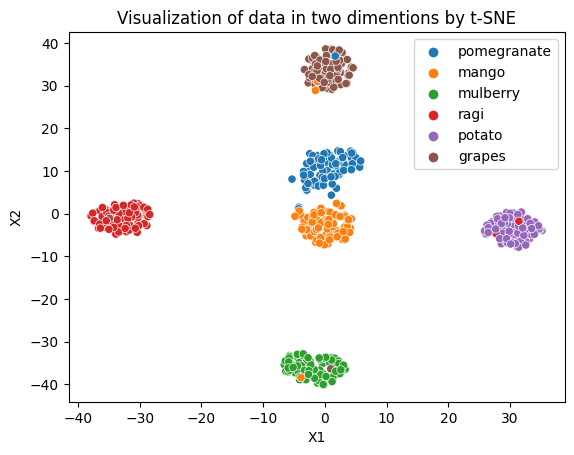

In [41]:
g = sns.scatterplot(data=tsne, x=tsne[:,0], y=tsne[:,1], hue=y_train.values)
g.set(xlabel='X1', ylabel='X2', title='Visualization of data in two dimentions by t-SNE')

# Modeling


Random Forest

AdaBoost

SVM

KNN

Logistic regression

Gradient Boosting

In [42]:
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

from sklearn.metrics import ConfusionMatrixDisplay

Hyperparameter tunning

In [43]:
le = LabelEncoder()
y_train_gb = le.fit_transform(y_train)

In [44]:
# choosing best estimators for Random Forest model:
param_grid = {'max_depth': [2, 3, 4, 5, 6, 10, 100, 300], 'n_estimators':[100, 500, 1000]}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid)
rf_model.fit(X_train, y_train)
print(f"Best estimators for Random Forest: {rf_model.best_estimator_}")

# choosing best estimators for AdaBoost model:
param_grid = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.1, 0.2, 0.5, 0.7, 0.8, 1]}
ada_model = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid)
ada_model.fit(X_train, y_train)
print(f"Best estimators for AdaBoost: {ada_model.best_estimator_}")

# choosing best estimators for svm model:
param_grid = {'kernel': ['linear','poly','rbf'], 'C': [0.001, 0.01, 0.1, 1, 10],
                  'gamma': [1, 0.1]}
svm_model = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid)
svm_model.fit(X_train_scaled, y_train)
print(f"Best estimators for SVM: {svm_model.best_estimator_}")

# choosing best estimators for KNN model:
param_grid = {'n_neighbors': list(range(3, 16, 2))}
knn_model = GridSearchCV(KNeighborsClassifier(), param_grid)
knn_model.fit(X_train_scaled, y_train)
print(f"Best estimators for K-Nearest Neighbor: {knn_model.best_estimator_}")

# choosing best estimators for Gradient Boosting model:
param_grid = {'n_estimators': [10, 20, 50, 100, 300, 500], 'learning_rate': [0.1, 0.8, 1], 'max_depth' : [1, 2, 3, 5]}
gb_model = GridSearchCV(XGBClassifier(random_state=42), param_grid)
gb_model.fit(X_train, y_train_gb)
print(f"Best estimators for Gradient Boosting: {gb_model.best_estimator_}")

Best estimators for Random Forest: RandomForestClassifier(max_depth=2, random_state=42)
Best estimators for AdaBoost: AdaBoostClassifier(learning_rate=0.2, n_estimators=20, random_state=42)
Best estimators for SVM: SVC(C=0.1, class_weight='balanced', gamma=1, kernel='poly', random_state=42)
Best estimators for K-Nearest Neighbor: KNeighborsClassifier(n_neighbors=7)
Best estimators for Gradient Boosting: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=

In [45]:
rf = RandomForestClassifier(max_depth=2, random_state=42)
ada = AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)
svm = SVC(kernel='poly', C=0.1, class_weight='balanced', gamma=1, probability=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=7)
log = LogisticRegression(max_iter=400, random_state=42)
gb = XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=1, random_state=42)

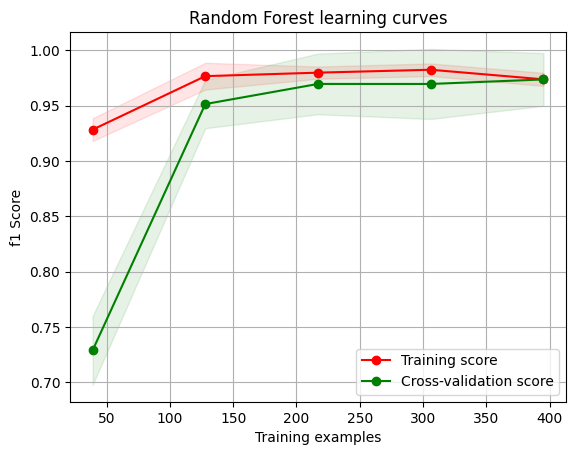

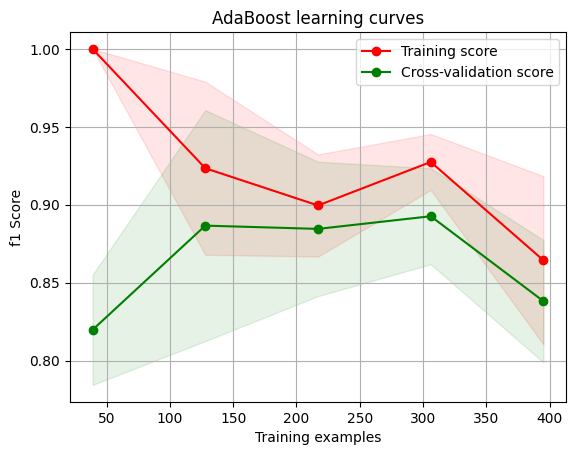

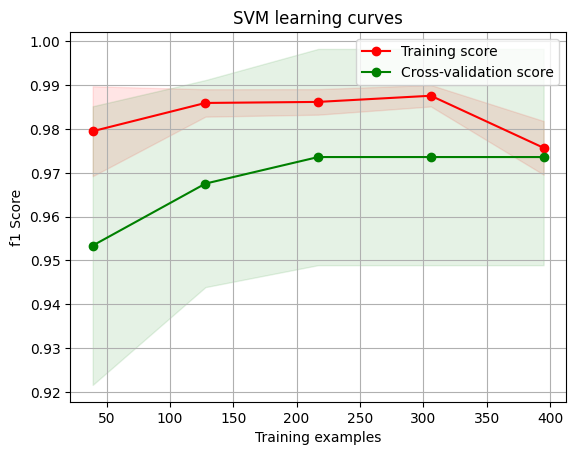

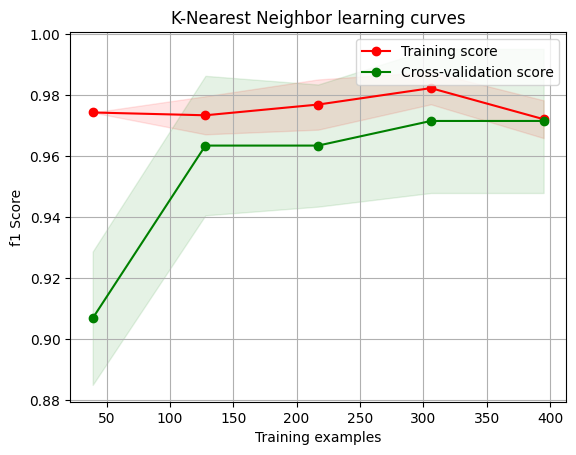

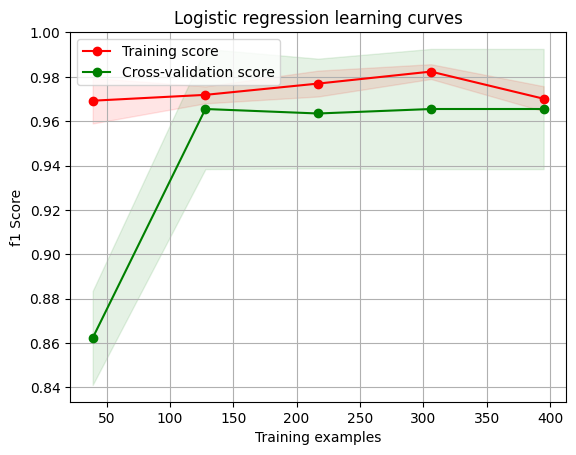

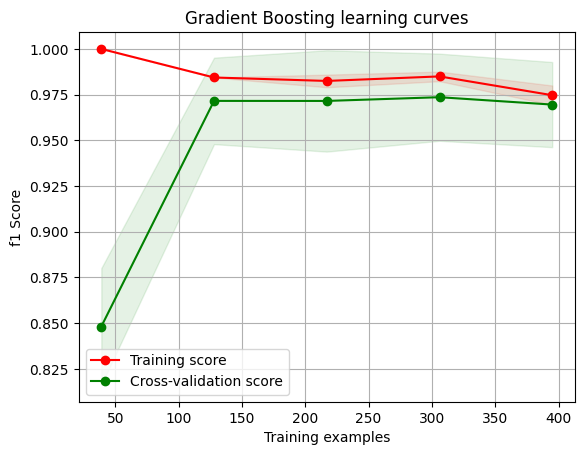

In [47]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring='f1_micro',
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("f1 Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_micro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt, test_scores_mean, test_scores_std


g, rf_mean, rf_std = plot_learning_curve(rf,"Random Forest learning curves",X_train,y_train,cv=5)
g, ada_mean, ada_std = plot_learning_curve(ada,"AdaBoost learning curves",X_train,y_train,cv=5)
g, svm_mean, svm_std = plot_learning_curve(svm,"SVM learning curves",X_train_scaled,y_train,cv=5)
g, knn_mean, knn_std = plot_learning_curve(knn,"K-Nearest Neighbor learning curves",X_train_scaled,y_train,cv=5)
g, log_mean, log_std = plot_learning_curve(log,"Logistic regression learning curves",X_train_scaled,y_train,cv=5)
g, gb_mean, gb_std = plot_learning_curve(gb,"Gradient Boosting learning curves",X_train,y_train_gb,cv=5)

In [48]:
print(f"\nRandom Forest score: {rf_mean.mean():.2f} ({rf_std.mean():.2f})\n")
print(f"\nAdaBoost score: {ada_mean.mean():.2f} ({ada_std.mean():.2f})\n")
print(f"\nSVM score: {svm_mean.mean():.2f} ({svm_std.mean():.2f})\n")
print(f"\nK-Nearest Neighbor score: {knn_mean.mean():.2f} ({knn_std.mean():.2f})\n")
print(f"\nLogistic Regression score: {log_mean.mean():.2f} ({log_std.mean():.2f})\n")
print(f"\nGradient Boosting score: {gb_mean.mean():.2f} ({gb_std.mean():.2f})\n")


Random Forest score: 0.92 (0.03)


AdaBoost score: 0.86 (0.04)


SVM score: 0.97 (0.03)


K-Nearest Neighbor score: 0.96 (0.02)


Logistic Regression score: 0.94 (0.03)


Gradient Boosting score: 0.95 (0.03)

